## 0. Basic

### Display the some first `image_file_names` & `file_name.csv`

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# print out the names of the first 2 image_files (total = 4 images for train_imgaes & train_label_masks) with the train, test, submission.csv files & 5 file.hdf5
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:2]:
        print(os.path.join(dirname, filename))

/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/train_images/825c6002ff3ab0e041ebd7025ba41b4f.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/45d0ddf0aeb9b7f3c8e6c19c4405ac99.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/c699f572c40dbee492ca9ac0c1a0d9f7_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/78138d4fc0b8fceb04138cd44d4a4fdd_mask.tiff
/kaggle/input/pytable-hdf/img_dtbase_10000.h5
/kaggle/input/pytable-hdf/img_dtbase_7500.h5
/kaggle/input/h5-files/full_data_coordinate.h5


## 1. Basic libraries

### Loading & viewing dataset

In [2]:
import os
import openslide
import skimage.io
import random
import seaborn as sns
import cv2
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display
import plotly.graph_objs as go
from U_Net import *

BASE_PATH = '../input/prostate-cancer-grade-assessment'

data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')

train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

### 1. Loading database

In [3]:
id_dir = [name.replace('_mask.tiff', '') for name in os.listdir(mask_dir)]
id_dir.sort()
print(id_dir[:5])

id_dir.remove('3790f55cad63053e956fb73027179707')
img_id_mutual_name = id_dir
img_id_mutual_name[:5], len(img_id_mutual_name)

['0005f7aaab2800f6170c399693a96917', '000920ad0b612851f8e01bcc880d9b3d', '0018ae58b01bdadc8e347995b69f99aa', '001c62abd11fa4b57bf7a6c603a11bb9', '001d865e65ef5d2579c190a0e0350d8f']


(['0005f7aaab2800f6170c399693a96917',
  '000920ad0b612851f8e01bcc880d9b3d',
  '0018ae58b01bdadc8e347995b69f99aa',
  '001c62abd11fa4b57bf7a6c603a11bb9',
  '001d865e65ef5d2579c190a0e0350d8f'],
 10515)

In [4]:
import deepdish as dd

df = dd.io.load('/kaggle/input/h5-files/full_data_coordinate.h5')
len(df)//36, len(df[0]), df[0]

(9790, 5, ['0005f7aaab2800f6170c399693a96917', 13312, 13824, 7168, 7680])

In [6]:
cls = PANDADataset(data_dir, mask_dir, df[:18000], 2)
%time cls[0][0].size(), cls[0][1].size(), len(cls)

CPU times: user 72.6 ms, sys: 21.9 ms, total: 94.4 ms
Wall time: 278 ms


(torch.Size([3, 512, 512]), torch.Size([512, 512]), 18000)

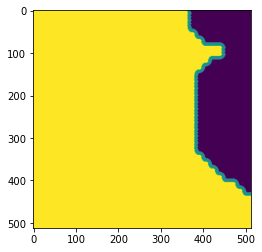

In [7]:
plt.imshow(cls[300][1])

### 3. Build the model
Adapted from [link](https://discuss.pytorch.org/t/unet-implementation/426)


#### Unet-params & training params
These parameters get fed directly into the UNET class, and more description of them can be discovered there

But here, I will try with epochs = 3

In [9]:
# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there

n_classes = 6    #number of classes in the data mask that we'll aim to predict


in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 7       #depth of the network 
wf= 2           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size = 8
patch_size = 512
num_epochs = 3
edge_weight = 1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

### 4. Decide what divice to run the model

In [10]:
gpuid=0
#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [11]:
dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase] = PANDADataset(data_dir, mask_dir, df)
    dataLoader[phase] = DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=8, pin_memory=True)

torch.Size([3, 512, 512]) torch.Size([512, 512])


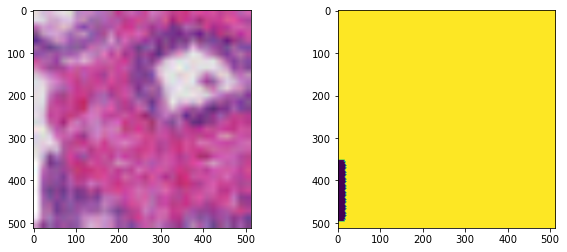

In [12]:
#visualize a single example to verify that it is correct
img, patch_mask_weight = dataset["train"][7]
fig, ax = plt.subplots(1, 2, figsize=(10,4))  # 1 row, 2 columns
print(img.shape, patch_mask_weight.shape)
#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask_weight)
plt.show()

In [13]:
dataLoader = DataLoader(cls, batch_size=8, shuffle=True, num_workers=8)
print(len(dataLoader))
del df, cls

2250


### 5. Fit the model according to the paramters specified above and copy it to the GPU.

In [14]:
model = UNet(n_classes=n_classes, in_channels=in_channels, 
             padding=padding,depth=depth,wf=wf, 
             up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust
criterion = nn.CrossEntropyLoss(reduce=False)

total params: 	1948854


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [15]:
import time
print('======================================== Training started ========================================')
for epoch in range(num_epochs):
    print('==================================================================================================')
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    
    t0 = time.time()
    for i, data in enumerate(dataLoader, 0):
        inputs, labels = data
        inputs = inputs.to(device,dtype=torch.float) 
        labels = labels.type('torch.LongTensor').to(device)
        ##with torch.set_grad_enabled(True):
        # zero the parameter gradients
        optim.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.sum().backward()
        optim.step()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
        train_accuracy = correct_train / total_train
        
        # print statistics
        running_loss += loss.mean()
        
        
        
        if i % 100 == 99:    # print every 400 mini-batches
            t1 = time.time()
            print('Epoch %02d, upto %05d mini-batches; after %02d (minutes) and %02d (seconds);  train_loss = %.3f'%
                  (epoch + 1, i + 1, (t1 - t0) // 60, (t1 - t0)%60, running_loss / 101))
            running_loss = 0.0
print('==================================================================================================')
print('======================================== Finished Training =======================================')

======================================== Training started ========================================
Epoch 01, upto 00100 mini-batches; after 00 (minutes) and 25 (seconds);  train_loss = 1.757
Epoch 01, upto 00200 mini-batches; after 00 (minutes) and 48 (seconds);  train_loss = 1.546
Epoch 01, upto 00300 mini-batches; after 01 (minutes) and 08 (seconds);  train_loss = 1.396
Epoch 01, upto 00400 mini-batches; after 01 (minutes) and 29 (seconds);  train_loss = 1.263
Epoch 01, upto 00500 mini-batches; after 01 (minutes) and 51 (seconds);  train_loss = 1.167
Epoch 01, upto 00600 mini-batches; after 02 (minutes) and 11 (seconds);  train_loss = 1.121
Epoch 01, upto 00700 mini-batches; after 02 (minutes) and 32 (seconds);  train_loss = 1.096
Epoch 01, upto 00800 mini-batches; after 02 (minutes) and 54 (seconds);  train_loss = 1.051
Epoch 01, upto 00900 mini-batches; after 03 (minutes) and 15 (seconds);  train_loss = 1.078
Epoch 01, upto 01000 mini-batches; after 03 (minutes) and 36 (seconds);  

In [16]:
type(dataLoader)

torch.utils.data.dataloader.DataLoader

#### 4. Evaluate & predict

In [ ]:
hdf5_dir = '.../input/h5-files/full_data_coordinate.h5'
df = dd.io.load(hdf5_dir)
cls_test = PANDADataset(data_dir, mask_dir, df[ : 80], 1)
a = cls_test[0][0].permute((1, 2, 0)).detach().squeeze().cpu().numpy()
b = cls_test[0][1].detach().squeeze().cpu().numpy()
cmap =  matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.subplot(121), plt.imshow(a)
plt.subplot(122), plt.imshow(b, cmap = cmap)
plt.show()

In [18]:
data_inp = []
predicts = []
true_mask = []
dataLoader_test = DataLoader(cls_test, batch_size=8, shuffle=True, num_workers=8)
for i, data in enumerate(dataLoader_test, 0):
    inputs, labels = data
    inputs = inputs.to(device,dtype = torch.float) 
    labels = labels.type('torch.LongTensor').to(device)
    predict = model(inputs)
    
    ## append
    predicts += predict
    data_inp += inputs
    true_mask += labels
    ## freeze
    del inputs, labels, predict, data
    
print(len(predicts), predicts[0].shape)
print(len(data_inp), data_inp[0].shape)
print(len(true_mask), true_mask[0].shape)

80 torch.Size([6, 512, 512])
80 torch.Size([3, 512, 512])
80 torch.Size([512, 512])


In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5.5))
for k in range(4):
    c = predicts[k][0].detach().squeeze().cpu().numpy()
    ax[k].imshow(c, cmap = cmap), ax[k].set_title('predict %s'%(k+1))
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(25, 5.5))
for k in range(4):
    d = true_mask[k].detach().squeeze().cpu().numpy()
    ax[k].imshow(d, cmap = cmap), ax[k].set_title('true_mask %s'%(k+1))
plt.show()

### Evaluating & grading

In [20]:
ID_list = os.listdir(mask_dir)
ID_list = [u.replace('_mask.tiff', '') for u in ID_list]

ID = ID_list[0]

#### Forecasted-scoring

In [36]:
x = split_get_coordinate(ID)
%time ISUP(x)

CPU times: user 6.46 s, sys: 1.05 s, total: 7.5 s
Wall time: 7.59 s


2